***POTENTIAL TALENTS***

As a talent sourcing and management company, we are interested in finding talented individuals for sourcing these candidates to technology companies. Finding talented candidates is not easy, for several reasons. The first reason is one needs to understand what the role is very well to fill in that spot, this requires understanding the client’s needs and what they are looking for in a potential candidate. The second reason is one needs to understand what makes a candidate shine for the role we are in search for. Third, where to find talented individuals is another challenge.

The nature of our job requires a lot of human labor and is full of manual operations. Towards automating this process we want to build a better approach that could save us time and finally help us spot potential candidates that could fit the roles we are in search for. Moreover, going beyond that for a specific role we want to fill in we are interested in developing a machine learning powered pipeline that could spot talented individuals, and rank them based on their fitness.

We are right now semi-automatically sourcing a few candidates, therefore the sourcing part is not a concern at this time but we expect to first determine best matching candidates based on how fit these candidates are for a given role. We generally make these searches based on some keywords such as “full-stack software engineer”, “engineering manager” or “aspiring human resources” based on the role we are trying to fill in. These keywords might change, and you can expect that specific keywords will be provided to you.

Assuming that we were able to list and rank fitting candidates, we then employ a review procedure, as each candidate needs to be reviewed and then determined how good a fit they are through manual inspection. This procedure is done manually and at the end of this manual review, we might choose not the first fitting candidate in the list but maybe the 7th candidate in the list. If that happens, we are interested in being able to re-rank the previous list based on this information. This supervisory signal is going to be supplied by starring the 7th candidate in the list. Starring one candidate actually sets this candidate as an ideal candidate for the given role. Then, we expect the list to be re-ranked each time a candidate is starred.

Ensemble model:
1. Get Data set
2. Preprocessing
3. word count
4. find and calculate vector
5. calculate cosine similarities
6. Word Embedding
7. Reranking 

In [1]:
pip install -U sentence-transformers


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 41.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 52.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 37.7 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=4a6f47e86b5ef5684f75abf42901c7ba429d5d6348620d8aa23c90145c8dd536
  Stored in directory: /root/.cache/pip/wheels/5e/6f/8c/d88aec621f3f542d26fac0342bef5e693335d125f4e54aeffe
Successfully built sentence-transformers


***IMPORT LIBRARIES***

In [45]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as mpl
import seaborn as sb
import numpy as np

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

from scipy.spatial.distance import cosine

from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import KeyedVectors, Word2Vec
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.test.utils import get_tmpfile

from sentence_transformers import SentenceTransformer
import random

# pytorch ( for reranking)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [4]:
#importing Data
from google.colab import files
 
 
uploaded = files.upload()

Saving potential-talents - Aspiring human resources - seeking human resources.csv to potential-talents - Aspiring human resources - seeking human resources.csv


In [5]:
#Read data
path = 'potential-talents - Aspiring human resources - seeking human resources.csv'
data = pd.read_csv(path, index_col='id')
data.head()
data

,job_title,location,connection,fit
id,,,,
1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN
2,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN
3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN
4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN
5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN
...,...,...,...,...
100,Aspiring Human Resources Manager | Graduating ...,"Cape Girardeau, Missouri",103,NaN
101,Human Resources Generalist at Loparex,"Raleigh-Durham, North Carolina Area",500+,NaN
102,Business Intelligence and Analytics at Travelers,Greater New York City Area,49,NaN


In [6]:
data.location.value_counts()


Kanada                                 12
Raleigh-Durham, North Carolina Area     8
Houston, Texas Area                     8
Greater New York City Area              7
Houston, Texas                          7
Denton, Texas                           6
San Francisco Bay Area                  5
Greater Philadelphia Area               5
İzmir, Türkiye                          4
Lake Forest, California                 4
Atlanta, Georgia                        4
Chicago, Illinois                       2
Austin, Texas Area                      2
Greater Atlanta Area                    2
Amerika Birleşik Devletleri             2
Long Beach, California                  1
Milpitas, California                    1
Greater Chicago Area                    1
Torrance, California                    1
Greater Los Angeles Area                1
Bridgewater, Massachusetts              1
Lafayette, Indiana                      1
Kokomo, Indiana Area                    1
Las Vegas, Nevada Area            

In [7]:
data.job_title.value_counts()

2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional                 7
Aspiring Human Resources Professional                                                                                    7
Student at Humber College and Aspiring Human Resources Generalist                                                        7
People Development Coordinator at Ryan                                                                                   6
Native English Teacher at EPIK (English Program in Korea)                                                                5
Aspiring Human Resources Specialist                                                                                      5
HR Senior Specialist                                                                                                     5
Student at Chapman University                                                                                            4
SVP, CHRO, Marke

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104 entries, 1 to 104
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   job_title   104 non-null    object 
 1   location    104 non-null    object 
 2   connection  104 non-null    object 
 3   fit         0 non-null      float64
dtypes: float64(1), object(3)
memory usage: 4.1+ KB


***Preprocessing***

original # of rows in data from is : 104
# of rows after cutting duplicates is : 53


Text(0.5, 0, 'number of candidates')

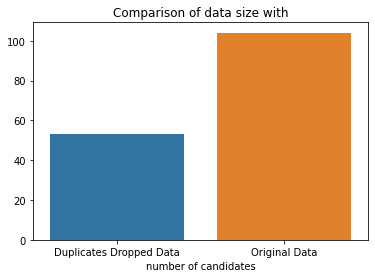

In [12]:
#clearing any duplicate
DupDropData = data.drop_duplicates()

print("original # of rows in data from is :", len(data))
print("# of rows after cutting duplicates is :", len(DupDropData))

#comparing graph
mpl.figure()
sb.barplot(x =['Duplicates Dropped Data','Original Data'],y=[len(DupDropData), len(data)])
mpl.title("Comparison of data size with")
mpl.xlabel("number of candidates")

In [13]:
#presenting datas
DupDropData.describe(include='all')

,job_title,location,connection
count,53,53,53
unique,52,41,33
top,Aspiring Human Resources Professional,"Houston, Texas Area",500+
freq,2,4,18


In [14]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [15]:
#removing stop words, punctuation, stemming, lower case

#copy set of data ( call them clean)
CleanData = DupDropData.copy()
CleanData['cleanJobTitle'] = ""

#stemming
stopword = set(stopwords.words('english'))
stemmed = PorterStemmer()

#for- loop for all datas
for i in DupDropData.index :
  JobTitle = DupDropData['job_title'][i]
  newstring = ''
  #lower casing
  newstring = newstring.lower()
  #shortening Human resource to HR
  newstring = JobTitle.replace("HR" , " human resources ")

  #intialize empty wordlist array for job title
  wordList = []

  for token in newstring.split() :
    word = ""
    #removing anything other than letters and numbers
    string = list([e for e in token if e.isalnum()])
    #attach them back together
    word = "" . join(string)
    #stemming words
    word = stemmed.stem(word)

    if word not in stopword :
      wordList.append(word)

    # attaching token from word list array with space in between
  cleanJobTitle = " ". join(wordList)

  CleanData['cleanJobTitle'][i] = cleanJobTitle



In [16]:
CleanData.head()

,job_title,location,connection,cleanJobTitle
id,,,,
1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,2019 ct bauer colleg busi graduat magna cum la...
2,Native English Teacher at EPIK (English Progra...,Kanada,500+,nativ english teacher epik english program korea
3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,aspir human resourc profession
4,People Development Coordinator at Ryan,"Denton, Texas",500+,peopl develop coordin ryan
5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,advisori board member celal bayar univers


***Similarity and scores***

In this step, we initially generate similarity score based on "Aspiring human resource " and "Seeking human resource" 

The method : Vectorizing both job title and using various vetorizer , then calculate cosine similarity between them

In [17]:
#initially seach phrase on job title list
SearchedPhrase = ['aspiring human resources' ,' seeking human resources' ]
#stemming the phrase
for i in range(len(SearchedPhrase)) : 
  pha = SearchedPhrase[i]
  stemmedpha = ""
  for token in pha.split() :
    word = stemmed.stem(token)
    stemmedpha += " " + word
  SearchedPhrase[i] = pha

JobTitleList = list(CleanData['cleanJobTitle'])

TF-IDF Cosine similarity score

In this step, we calculate the relevency of word in phrase

In [18]:
def cosinesimilarity(vector1, vector2) :
  return 1 - cosine(vector1, vector2)

In [19]:
#calculate TFIDF in job title
vectorizer = TfidfVectorizer()
tfidfvector = vectorizer.fit_transform(list(CleanData['cleanJobTitle'])).toarray()

#calculate TFIDF in search phrase
searchedvector = vectorizer.transform(SearchedPhrase).toarray()

#print the output for both vector
print('Shape of Job title Tfidf vector is: ', tfidfvector.shape)
print('Shape of search phrases tfidf vector is: ', searchedvector.shape)


Shape of Job title Tfidf vector is:  (53, 169)
Shape of search phrases tfidf vector is:  (2, 169)


In [20]:
#calculate TFIDF CSS average of job title to searched phrases
CSS = []
score1Arr = []
score2Arr = []

for i in range(len(CleanData)) :
  score1 = cosinesimilarity(tfidfvector[i],searchedvector[0])
  score2 = cosinesimilarity(tfidfvector[i],searchedvector[1])
  score1Arr.append(score1) 
  score2Arr.append(score2)
  CSS.append((score1+score2)/2)

CleanData['score1'] = score1Arr
CleanData['score2'] = score2Arr
CleanData['CSS'] = CSS


In [21]:
CleanData[['job_title', 'cleanJobTitle', 'CSS']].sort_values(by=['CSS'], ascending=False).head()

,job_title,cleanJobTitle,CSS
id,,,
74,Human Resources Professional,human resourc profession,0.430380
10,Seeking Human Resources HRIS and Generalist Po...,seek human resourc human resourc generalist posit,0.422995
73,"Aspiring Human Resources Manager, seeking inte...",aspir human resourc manag seek internship huma...,0.397974
3,Aspiring Human Resources Professional,aspir human resourc profession,0.349336
97,Aspiring Human Resources Professional,aspir human resourc profession,0.349336


***Word Embedding***

This step is used to lower dimentional of vector to increase the similarity and reduce dissimilarity

word2Vec -> shallow neural network with an input layer, a projection layer and an output layer. It is trained to reconstruct linguistic contexts of words

  a) Skip-gram : using word to predict a target context
  
  b) CBOW : using context to predict a target

GloVe -> Global vector


**Word2Vec**

***Global Vectors***

In [23]:
from google.colab import files
 
 
uploaded = files.upload()

Saving glove.6B.50d.txt to glove.6B.50d.txt


In [24]:
# for this part, we need to create a file, apply embedding to it and the convert it and save it as binary
targ = get_tmpfile('glove.6B.50d.txt')
glove2word2vec('glove.6B.50d.txt', targ)

GloVeModel = KeyedVectors.load_word2vec_format(targ)
GloVeModel.save_word2vec_format('glove.6B.50d.txt', binary=True)


In [25]:
#create function for that
def tokVec(sentence, model, Dimension) :
  tok = word_tokenize(sentence)
  filterword = [p for p in tok if p in model.index2word]

  for potential in tok : 
    if potential in filterword :
      tokVec = model[potential]
  
  return tokVec

In [26]:
  >>> import nltk
  >>> nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [27]:
#now applying this model into our file
GloVeVec = []
for job in CleanData['cleanJobTitle'] :
  GloVeVec.append(tokVec(job, GloVeModel, 50))

searchedvector = []
for phrase in SearchedPhrase :
  searchedvector.append(tokVec(phrase, GloVeModel, 50))


In [28]:
#calculate similarity 
GloVeScore = []
for i in range(len(GloVeVec)) :
  score1 = cosinesimilarity(GloVeVec[i], searchedvector[0])
  score2 = cosinesimilarity(GloVeVec[i], searchedvector[1])
  GloVeScore.append((score1+score2)/2)

CleanData['GloVe Score'] = GloVeScore
CleanData[['job_title', 'cleanJobTitle', 'GloVe Score']].sort_values(by=['GloVe Score'], ascending=False).head()

,job_title,cleanJobTitle,GloVe Score
id,,,
81,Senior Human Resources Business Partner at Hei...,senior human resourc busi partner heil environ...,0.742206
80,Junior MES Engineer| Information Systems,junior engin inform system,0.590565
88,Human Resources Management Major,human resourc manag major,0.586644
72,Business Management Major and Aspiring Human R...,busi manag major aspir human resourc manag,0.563923
73,"Aspiring Human Resources Manager, seeking inte...",aspir human resourc manag seek internship huma...,0.563923


***IMPORTANT NOTE***

Based on different reseaches, W2v has lower score than other model hence it may affect the average. To prevent that, I applied BERT model which is bidirectional encoder representation and transformers.

advantage : faster as models are already trained
higher score and it is used for larger data set which can be useful for our model

In [29]:
#building the model
BERTM = SentenceTransformer('bert-base-nli-mean-tokens')

#calculate job vector based on BERT MODEL
BERTVec = BERTM.encode(list(CleanData['cleanJobTitle']))
#calculate phrase vector based on BERRT MODEOL
BERTSerVec = BERTM.encode(list(SearchedPhrase))

#print shape of them

print('Shape of Job title in BERT MODEL is: ', BERTVec.shape)
print('Shape of search phrases in BERT MODEL is: ', BERTSerVec.shape)

Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.95k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/399 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Shape of Job title in BERT MODEL is:  (53, 768)
Shape of search phrases in BERT MODEL is:  (2, 768)


In [30]:
#calculate CSS
BERTScore = []
for i in range(len(GloVeScore)) :
  score1 = cosinesimilarity(BERTVec[i], BERTSerVec[0])
  score2 = cosinesimilarity(BERTVec[i], BERTSerVec[1])
  BERTScore.append((score1+score2)/2)

CleanData['BERT Score'] = BERTScore
CleanData[['job_title', 'cleanJobTitle', 'BERT Score']].sort_values(by=['BERT Score'], ascending=False).head()

,job_title,cleanJobTitle,BERT Score
id,,,
28,Seeking Human Resources Opportunities,seek human resourc opportun,0.757105
99,Seeking Human Resources Position,seek human resourc posit,0.713162
74,Human Resources Professional,human resourc profession,0.699594
67,"Human Resources, Staffing and Recruiting Profe...",human resourc staf recruit profession,0.685327
89,Director Human Resources at EY,director human resourc ey,0.676749


AVG of Similarities

In [32]:
totalScore = CleanData.columns[[6,7,8]]
CleanData['Avg Score'] = CleanData[totalScore].mean(axis=1)
CleanData[['job_title', 'cleanJobTitle', 'Avg Score']].sort_values(by=['Avg Score'],ascending=False).head()

,job_title,cleanJobTitle,Avg Score
id,,,
28,Seeking Human Resources Opportunities,seek human resourc opportun,0.536690
73,"Aspiring Human Resources Manager, seeking inte...",aspir human resourc manag seek internship huma...,0.514518
74,Human Resources Professional,human resourc profession,0.511600
88,Human Resources Management Major,human resourc manag major,0.492045
6,Aspiring Human Resources Specialist,aspir human resourc specialist,0.476520


***ReRank ***

Working of RankNet

A neural network with Linear, Dropout and activation layers is built which takes job title as input and returns a prediction.
Two random samples from the job titles are selected and their output is computed separately using forward propagation.
The cost, which is the difference between the two outputs is calculated and appropriate loss is calculated.
The loss is back-propogated to learn the selected example.
Steps 2-4 are repeated until the training is complete based on epochs.

In [50]:
#copy new set of data
RankingData = CleanData.copy()
RankingData = RankingData.dropna()
RankingData.head()

,job_title,location,connection,cleanJobTitle,score1,score2,CSS,GloVe Score,BERT Score,Avg Score
id,,,,,,,,,,
1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,2019 ct bauer colleg busi graduat magna cum la...,0.108627,0.108627,0.108627,0.404827,0.399579,0.304344
2,Native English Teacher at EPIK (English Progra...,Kanada,500+,nativ english teacher epik english program korea,0.000000,0.000000,0.000000,0.373315,0.386845,0.253387
3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,aspir human resourc profession,0.349336,0.349336,0.349336,0.404827,0.639264,0.464476
4,People Development Coordinator at Ryan,"Denton, Texas",500+,peopl develop coordin ryan,0.000000,0.000000,0.000000,0.121904,0.574026,0.231977
5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,advisori board member celal bayar univers,0.000000,0.000000,0.000000,-0.403762,0.486016,0.027418


In [51]:
#Ask Question

STARCan = input("Do you want to star any candidates? Enter 'yes' or 'no': ")

starcand = []
if STARCan == 'yes' :
  starcand = [int(item) for item in input("Enter ids of candidates you want to star (separated by space) : ").split()]

Do you want to star any candidates? Enter 'yes' or 'no': yes
Enter ids of candidates you want to star (separated by space) : 2 6 8 


In [35]:
starcand

[2, 4, 72, 90]

In [52]:
#adding Starred score to columns
RankingData['starredScore'] = RankingData['Avg Score']

for id in starcand:
        RankingData.at[id , 'starredScore'] = 1
RankingData.head()

,job_title,location,connection,cleanJobTitle,score1,score2,CSS,GloVe Score,BERT Score,Avg Score,starredScore
id,,,,,,,,,,,
1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,2019 ct bauer colleg busi graduat magna cum la...,0.108627,0.108627,0.108627,0.404827,0.399579,0.304344,0.304344
2,Native English Teacher at EPIK (English Progra...,Kanada,500+,nativ english teacher epik english program korea,0.000000,0.000000,0.000000,0.373315,0.386845,0.253387,1.000000
3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,aspir human resourc profession,0.349336,0.349336,0.349336,0.404827,0.639264,0.464476,0.464476
4,People Development Coordinator at Ryan,"Denton, Texas",500+,peopl develop coordin ryan,0.000000,0.000000,0.000000,0.121904,0.574026,0.231977,0.231977
5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,advisori board member celal bayar univers,0.000000,0.000000,0.000000,-0.403762,0.486016,0.027418,0.027418


In [53]:
# Set seed for reproducability
random.seed(42)

#build the RankNet Class 
class RankNet(nn.Module):
    
    def __init__(self, num_feature):
        super(RankNet, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(num_feature, 512),         # Linear layer - linear projection
            nn.Dropout(0.5),                     # Regularization - Drops some of the neurons in a random fashion
            nn.LeakyReLU(0.2, inplace=True),     # Activation function
            nn.Linear(512, 256),
            nn.Dropout(0.5),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()                         # Applies a function on the output and brings the output bw 0 and 1
        )
        self.output_sig = nn.Sigmoid()

    def forward(self, input_1, input_2):
        s1 = self.model(input_1)
        s2 = self.model(input_2)
        out = self.output_sig(s1-s2)
        return out
    
    def predict(self, input_):
        s = self.model(input_)
        return s

In [54]:
bert_model = SentenceTransformer('bert-base-nli-mean-tokens')


In [55]:
random_row_1 = RankingData.sample(n = 5000, replace = True)
random_row_2 = RankingData.sample(n = 5000, replace = True)

In [56]:
job_title_list_ranknet1 = list(random_row_1['cleanJobTitle'])
job_title_list_ranknet2 = list(random_row_2['cleanJobTitle'])

In [48]:
print(job_title_list_ranknet1)

['nortia staf seek human resourc payrol  administr profession 408 7092621', 'aspir human resourc profession  energet teamfocus leader', 'aspir human resourc profession  passion help creat inclus engag work environ', 'seek human resourc human resourc generalist posit', 'student', 'nativ english teacher epik english program korea', '2019 ct bauer colleg busi graduat magna cum laud aspir human resourc profession', 'director human resourc ey', 'busi intellig analyt travel', 'nortia staf seek human resourc payrol  administr profession 408 7092621', 'nativ english teacher epik english program korea', 'student westfield state univers', 'nortia staf seek human resourc payrol  administr profession 408 7092621', 'busi intellig analyt travel', 'retir armi nation guard recruit offic manag seek posit human resourc', 'aspir human resourc profession', 'undergradu research assist styczynski lab', 'human resourc manag major', 'aspir human resourc profession', 'busi intellig analyt travel', 'busi intell

In [57]:
RankingData.head()

,job_title,location,connection,cleanJobTitle,score1,score2,CSS,GloVe Score,BERT Score,Avg Score,starredScore
id,,,,,,,,,,,
1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,2019 ct bauer colleg busi graduat magna cum la...,0.108627,0.108627,0.108627,0.404827,0.399579,0.304344,0.304344
2,Native English Teacher at EPIK (English Progra...,Kanada,500+,nativ english teacher epik english program korea,0.000000,0.000000,0.000000,0.373315,0.386845,0.253387,1.000000
3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,aspir human resourc profession,0.349336,0.349336,0.349336,0.404827,0.639264,0.464476,0.464476
4,People Development Coordinator at Ryan,"Denton, Texas",500+,peopl develop coordin ryan,0.000000,0.000000,0.000000,0.121904,0.574026,0.231977,0.231977
5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,advisori board member celal bayar univers,0.000000,0.000000,0.000000,-0.403762,0.486016,0.027418,0.027418


In [58]:
RankingData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53 entries, 1 to 104
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   job_title      53 non-null     object 
 1   location       53 non-null     object 
 2   connection     53 non-null     object 
 3   cleanJobTitle  53 non-null     object 
 4   score1         53 non-null     float64
 5   score2         53 non-null     float64
 6   CSS            53 non-null     float64
 7   GloVe Score    53 non-null     float64
 8   BERT Score     53 non-null     float64
 9   Avg Score      53 non-null     float64
 10  starredScore   53 non-null     float64
dtypes: float64(7), object(4)
memory usage: 7.0+ KB


In [59]:
doc1 = bert_model.encode(job_title_list_ranknet1)
doc2 = bert_model.encode(job_title_list_ranknet2)
doc1 = torch.from_numpy(doc1).float()
doc2 = torch.from_numpy(doc2).float()

In [60]:
# Generate ground truth for RankNet model
y1 = list(random_row_1['starredScore'])
y2 = list(random_row_2['starredScore'])
y = torch.tensor([1.0 if y1_i>y2_i 
                  else 0.5 if y1_i==y2_i 
                  else 0.0 
                  for y1_i, y2_i in zip(y1, y2)]).float()
y = y.unsqueeze(1)

In [61]:
# Initialize an instance of RankNet model and define loss function
rank_model = RankNet(num_feature = 768)
# optimizer = torch.optim.Adam(rank_model.parameters())         
optimizer = torch.optim.SGD(rank_model.parameters(), lr = 0.01, momentum = 0.9)        
loss_fun = torch.nn.BCELoss()             # BCE is generally used for NLP problems

In [62]:
# Run RankNet model through various iterations until loss is optimized
epoch = 3000
losses = []

for i in range(epoch):
    rank_model.zero_grad()
    y_pred = rank_model(doc1, doc2)
    loss = loss_fun(y_pred,y)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    #print(y1, y2, y, y_pred)
    
    if i % 100 == 0:
        print('Epoch{}, loss : {}'.format(i, loss.item()))

Epoch0, loss : 0.6943328380584717
Epoch100, loss : 0.6180972456932068
Epoch200, loss : 0.5540270209312439
Epoch300, loss : 0.5333885550498962
Epoch400, loss : 0.5159984827041626
Epoch500, loss : 0.506967306137085
Epoch600, loss : 0.5041059851646423
Epoch700, loss : 0.5015290975570679
Epoch800, loss : 0.5004571080207825
Epoch900, loss : 0.4996405243873596
Epoch1000, loss : 0.4986754357814789
Epoch1100, loss : 0.5000619888305664
Epoch1200, loss : 0.5002179741859436
Epoch1300, loss : 0.49977201223373413
Epoch1400, loss : 0.49997079372406006
Epoch1500, loss : 0.4986193776130676
Epoch1600, loss : 0.49951669573783875
Epoch1700, loss : 0.498996764421463
Epoch1800, loss : 0.49848008155822754
Epoch1900, loss : 0.4988355338573456
Epoch2000, loss : 0.4983046352863312
Epoch2100, loss : 0.49915942549705505
Epoch2200, loss : 0.4981434941291809
Epoch2300, loss : 0.49874046444892883
Epoch2400, loss : 0.4993739128112793
Epoch2500, loss : 0.4981011152267456
Epoch2600, loss : 0.49864932894706726
Epoch270

Text(0.5, 1.0, 'Loss vs Epochs graph ')

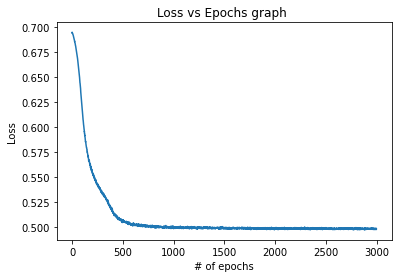

In [63]:
# Plot a graph for loss vs number of iterations 
x = list(range(3000))
mpl.plot(x, losses)
mpl.xlabel("# of epochs")
mpl.ylabel("Loss")
mpl.title("Loss vs Epochs graph ")

In [64]:
# Make predictions for the initial dataset and create a new column for final cosine similarity
predScore = []
for job in RankingData['cleanJobTitle'] :
    embedding = bert_model.encode([job])
    embedding_tensor = torch.from_numpy(embedding).float()
    pred = round(rank_model.predict(embedding_tensor).detach().numpy().sum(),2)
    predScore.append(pred)

RankingData['RankNN_score'] = predScore
RankingData.sort_values(by ='RankNN_score', ascending = False)

,job_title,location,connection,cleanJobTitle,score1,score2,CSS,GloVe Score,BERT Score,Avg Score,starredScore,RankNN_score
id,,,,,,,,,,,,
67,"Human Resources, Staffing and Recruiting Profe...","Jackson, Mississippi Area",500+,human resourc staf recruit profession,0.219673,0.219673,0.219673,0.404827,0.685327,0.436609,0.436609,1.00
94,Seeking Human Resources Opportunities. Open t...,Amerika Birleşik Devletleri,415,seek human resourc opportun open travel reloc,0.161551,0.161551,0.161551,0.440557,0.555716,0.385941,0.385941,1.00
2,Native English Teacher at EPIK (English Progra...,Kanada,500+,nativ english teacher epik english program korea,0.000000,0.000000,0.000000,0.373315,0.386845,0.253387,1.000000,1.00
77,Human Resources|\nConflict Management|\nPolici...,Dallas/Fort Worth Area,409,human resourc conflict manag polici procedure...,0.138528,0.138528,0.138528,0.417155,0.583207,0.379630,0.379630,1.00
97,Aspiring Human Resources Professional,"Kokomo, Indiana Area",71,aspir human resourc profession,0.349336,0.349336,0.349336,0.404827,0.639264,0.464476,0.464476,1.00
74,Human Resources Professional,Greater Boston Area,16,human resourc profession,0.430380,0.430380,0.430380,0.404827,0.699594,0.511600,0.511600,1.00
73,"Aspiring Human Resources Manager, seeking inte...","Houston, Texas Area",7,aspir human resourc manag seek internship huma...,0.397974,0.397974,0.397974,0.563923,0.581655,0.514518,0.514518,1.00
72,Business Management Major and Aspiring Human R...,"Monroe, Louisiana Area",5,busi manag major aspir human resourc manag,0.182161,0.182161,0.182161,0.563923,0.466361,0.404148,0.404148,1.00
70,"Retired Army National Guard Recruiter, office ...","Virginia Beach, Virginia",82,retir armi nation guard recruit offic manag se...,0.121921,0.121921,0.121921,0.563923,0.463700,0.383181,0.383181,1.00


***CONCLUSION***

In conclusion, I used differnet models( with highest score) in NLP such as GloVe, BERT and TF-IDF for two given phrase. By applying cosine similarity score for each model and then take the average of all, the model ranked. After that I reranked them based on starred candidate and used model was RankNet which is a deep learning model.

By comparing the above graph and starred candidate, it is shown that those candidate has starred score of 1.


